In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Read the cleaned file (change the name if yours is different)
FILE = "googleplaystore_clean.csv"
df = pd.read_csv(FILE)

In [20]:
print(df.head(5))

         Category  Size  Installs  Type  Price Content Rating  \
0  ART_AND_DESIGN  19.0     10000  Free    0.0       Everyone   
1  ART_AND_DESIGN  14.0    500000  Free    0.0       Everyone   
2  ART_AND_DESIGN   8.7   5000000  Free    0.0       Everyone   
3  ART_AND_DESIGN  25.0  50000000  Free    0.0           Teen   
4  ART_AND_DESIGN   2.8    100000  Free    0.0       Everyone   

                      Genres  Android Ver  
0               Art & Design            4  
1  Art & Design;Pretend Play            4  
2               Art & Design            4  
3               Art & Design            4  
4    Art & Design;Creativity            4  


In [21]:
# show summary for all dtypes
print(df.describe(include='all'))


       Category         Size      Installs  Type        Price Content Rating  \
count      9660  9660.000000  9.660000e+03  9660  9660.000000           9660   
unique       33          NaN           NaN     2          NaN              6   
top      FAMILY          NaN           NaN  Free          NaN       Everyone   
freq       1832          NaN           NaN  8904          NaN           7904   
mean        NaN    20.392815  7.776702e+06   NaN     1.099185            NaN   
std         NaN    20.393638  5.375555e+07   NaN    16.851283            NaN   
min         NaN     0.010000  0.000000e+00   NaN     0.000000            NaN   
25%         NaN     5.300000  1.000000e+03   NaN     0.000000            NaN   
50%         NaN    16.000000  1.000000e+05   NaN     0.000000            NaN   
75%         NaN    25.000000  1.000000e+06   NaN     0.000000            NaN   
max         NaN   100.000000  1.000000e+09   NaN   400.000000            NaN   

       Genres  Android Ver  
count    9

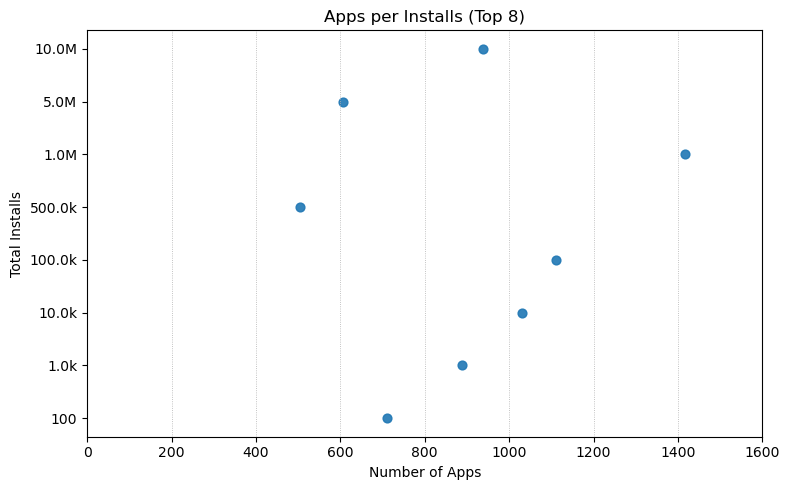

In [22]:
# Count how many apps per installs bucket
freq = df["Installs"].value_counts().sort_values(ascending=False)

# Take top 8 by count
top8 = freq.head(8).reset_index()
top8.columns = ["Installs", "apps_count"]

# Sort by installs size so Y reads from small to large
top8 = top8.sort_values("Installs").reset_index(drop=True)

# place the lable 
def human_k(n: int) -> str:
    if n >= 1_000_000_000:
        v = n / 1_000_000_000
        return f"{v:.1f}B".rstrip("0").rstrip(".")
    if n >= 1_000_000:
        v = n / 1_000_000
        return f"{v:.1f}M".rstrip("0").rstrip(".")
    if n >= 1_000:
        v = n / 1_000
        return f"{v:.1f}k".rstrip("0").rstrip(".")
    return str(n)
# x and y axis
y_pos   = np.arange(len(top8))
y_labels= [human_k(v) for v in top8["Installs"]]
x_vals  = top8["apps_count"].values

plt.figure(figsize=(8,5))
plt.scatter(x_vals, y_pos, s=40, alpha=0.9)
plt.xticks(np.arange(0, 1601, 200))  # 0,200,400,...,1600, increment 200 in x axis
plt.xlim(0, 1600)

plt.yticks(y_pos, y_labels)
plt.xlabel("Number of Apps")
plt.ylabel("Total Installs")
plt.title("Apps per Installs (Top 8)")

plt.grid(True, linestyle=":", linewidth=0.6, axis="x")
plt.tight_layout()
plt.show()

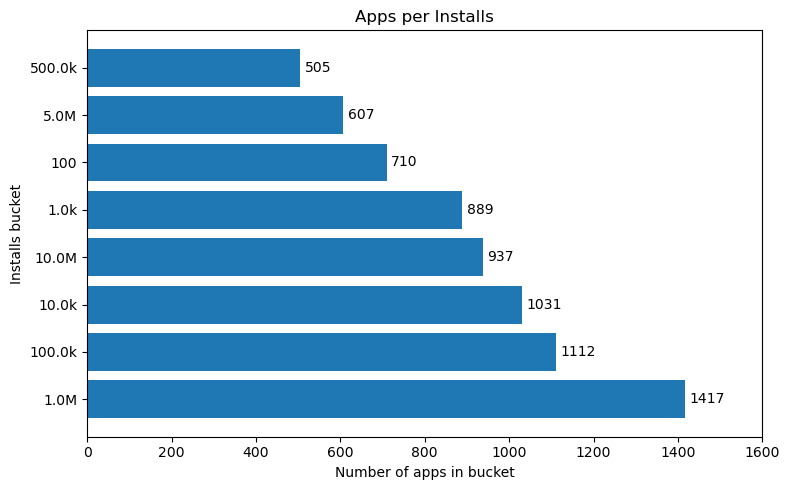

In [ ]:
# top 8 by app count 
top8 = df["Installs"].value_counts().sort_values(ascending=False).head(8)

# labels like 1k, 100k, 1M
def FormatInstall_k(n):
    for v, s in [(1_000_000_000, "B"), (1_000_000, "M"), (1_000, "k")]:
        if n >= v: 
            x = n / v
            return f"{x:.1f}{s}".rstrip("0").rstrip(".")
    return str(n)

labels = [FormatInstall_k(v) for v in top8.index]

# horizontal bar 
plt.figure(figsize=(8,5))
ypos = np.arange(len(top8))
plt.barh(ypos, top8.values)
for y, c in enumerate(top8.values):
    plt.text(c + 10, y, str(c), va="center")  # show the count at bar 
plt.yticks(ypos, labels)
plt.xlabel("Number of apps")
plt.ylabel("Total Installs")
plt.title("Apps per Installs")
plt.xlim(0, 1600) # 0..1600 scale
plt.xticks(np.arange(0, 1601, 200))

plt.tight_layout()
plt.show()


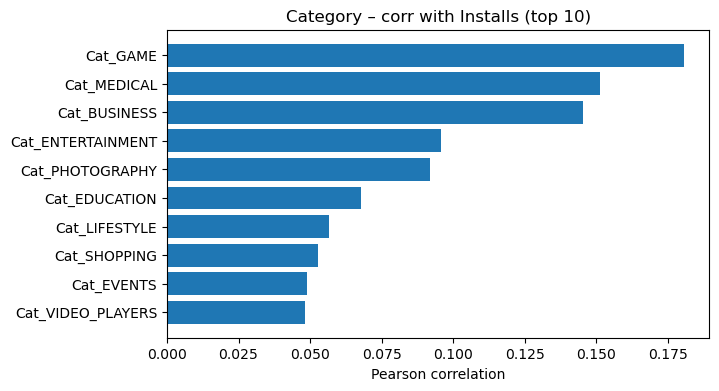

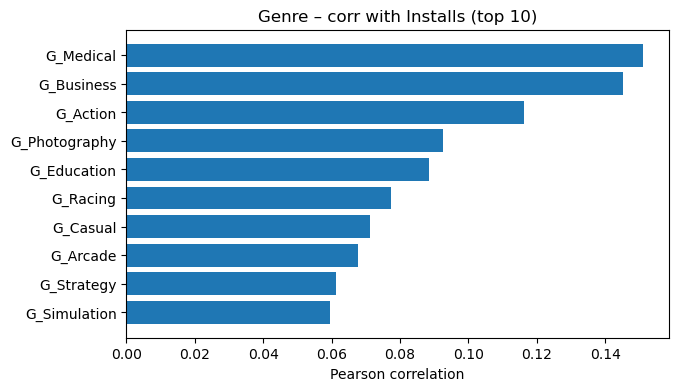

In [23]:
# correlation function
def corr_abs_series(y, X_dummies):
    def _c(s):
        pair = pd.concat([y, s], axis=1).dropna()
        return pair.iloc[:,0].corr(pair.iloc[:,1]) 
    return X_dummies.apply(_c).abs()

# clean installs and log1p
inst_raw = df["Installs"]
inst_log = np.log1p(inst_raw)

# Correlation with install
min_count = 30
keep_cats = df["Category"].value_counts()
keep_cats = keep_cats[keep_cats >= min_count].index
mask_cat = df["Category"].isin(keep_cats)
#one hot encoding
cat_dum = pd.get_dummies(df.loc[mask_cat, "Category"], prefix="Cat")
y_cat = inst_log[mask_cat] # use log1p target
cat_dum = cat_dum.loc[y_cat.index]       

# perform corrilation 
cat_corr = corr_abs_series(y_cat, cat_dum).sort_values(ascending=False).head(10)

plt.figure(figsize=(7,4))
plt.barh(cat_corr.index, cat_corr.values)
plt.title("Category – corr with Installs (top 10)")
plt.xlabel("Pearson correlation")
# Flips the y-axis so the largest correlation appears at the top.
plt.gca().invert_yaxis()
plt.show()

# correaltion for genre split ; in the dataset
df["Genre1"] = df["Genres"].astype(str).str.split(";").str[0]
keep_gen = df["Genre1"].value_counts()
keep_gen = keep_gen[keep_gen >= min_count].index
mask_gen = df["Genre1"].isin(keep_gen)

gen_dum = pd.get_dummies(df.loc[mask_gen, "Genre1"], prefix="G")
y_gen = inst_log[mask_gen]# use log1p target
gen_dum = gen_dum.loc[y_gen.index] 
gen_corr = corr_abs_series(y_gen, gen_dum).sort_values(ascending=False).head(10)

plt.figure(figsize=(7,4))
plt.barh(gen_corr.index, gen_corr.values)
plt.title("Genre – corr with Installs (top 10)")
plt.xlabel("Pearson correlation")
# Flips the y-axis so the largest correlation appears at the top.
plt.gca().invert_yaxis()
plt.show()


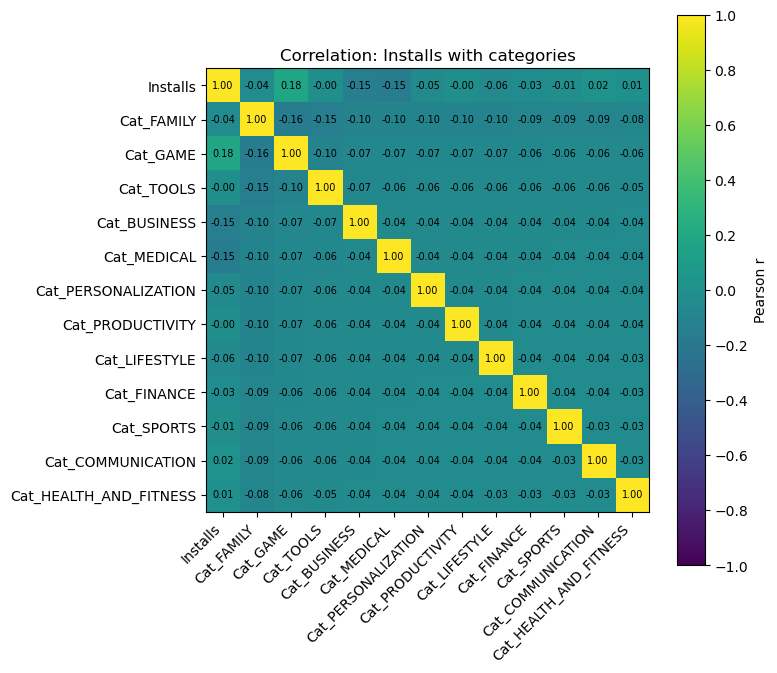

In [9]:
# pick only top 12 category
topK = 12
top_cats = df["Category"].value_counts().head(topK).index

# one-hot for those categories
D = pd.get_dummies(df["Category"])[top_cats].add_prefix("Cat_")

# clean installs then log1p
inst = pd.to_numeric(df["Installs"])
inst_log = np.log1p(inst).rename("Installs")

# build matrix with log installs
M = pd.concat([inst_log, D], axis=1).dropna().corr(method="pearson")

#add each value to list
labels = M.columns.tolist()
C = M.values

# each of the size
fig, ax = plt.subplots(figsize=(0.55*len(labels), 0.55*len(labels)))
# Colors are fixed so -1 is the darkest negative and +1 is the strongest positiv
im = ax.imshow(C, vmin=-1, vmax=1)
# x axis label
ax.set_xticks(range(len(labels))); ax.set_xticklabels(labels, rotation=45, ha="right")
#y axis label
ax.set_yticks(range(len(labels))); ax.set_yticklabels(labels)
#title 
ax.set_title("Correlation: Installs with categories")

# 2 decimal place in each cell
for i in range(len(labels)):
    for j in range(len(labels)):
        ax.text(j, i, f"{C[i,j]:.2f}", ha="center", va="center", fontsize=7, color="black")

# colour at the side
cb = fig.colorbar(im, ax=ax, ticks=np.arange(-1, 1.01, 0.2))
cb.set_label("Pearson r")
plt.show()


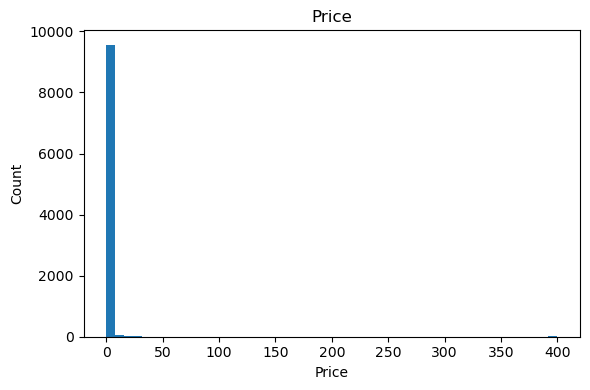

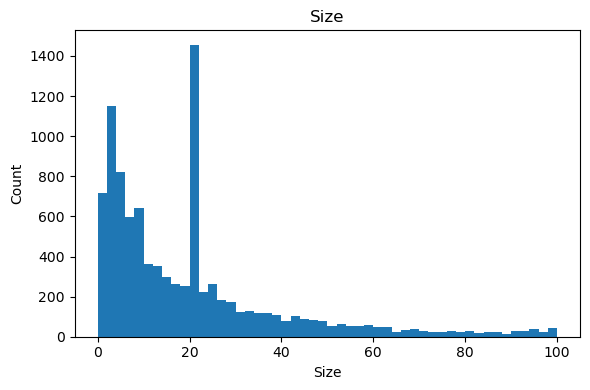

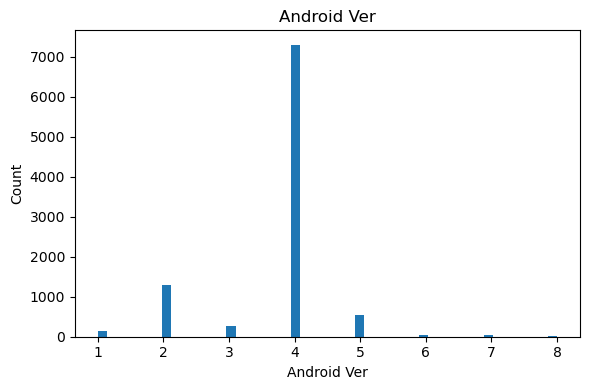

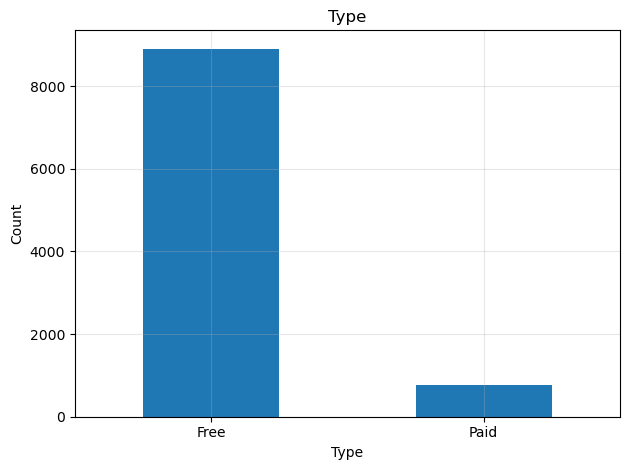

In [ ]:
# histogram
def hist1(series, title, bins=50, xlabel=None):
    s = pd.to_numeric(series)  # ensure numeric
    plt.figure(figsize=(6,4))
    plt.hist(s, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel or title)
    plt.ylabel("Count")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

#numeric columns
hist1(df["Price"], "Price")
hist1(df["Size"], "Size")
hist1(df["Android Ver"], "Android Ver")
# Two-bar chart: Free vs Paid 
df["Type"].value_counts().reindex(["Free","Paid"]).plot.bar(
    title="Type", ylabel="Count", rot = 0)
plt.grid(alpha=0.3)
plt.tight_layout(); 
plt.show()

